In [58]:
#sine function model
#importing essential librarys
#importing numpy
import numpy as np
#importing matplot libraray
import matplotlib.pyplot as plt
#importing random
import random

In [59]:
#setting seed to 0 to always get same set of numbers
np.random.seed(0)
#we can remove the zero to get unique results

In [60]:
#constants and hyperparameters
#setting total parameters to 200
TOTAL_SAMPLES = 4000
#define the layers or the architecture
#1D for input and 10D for 3 hidden layers along with 1D for output
LAYERS = [1,10,10,10,1]
#learning rate - value which we multiply with gradient before we use it to update the parameters
LEARNING_RATE = 0.1
#Epoch- it is the one forward pass and one backward pass of all the training examples 
#one epoch is finished once the network has seen all the dataset
#it is further used to improve the weight
N_EPOCH = 50_0000
#in this case case our network will see it 30_0000 times, this number can be changed acc to requirement

In [61]:
#dataset generation part 
#python convension is batch x spatial 
#drawing from a uniform distribution 
#all values will be in the range of sine function that is 0 to 2pi
#this all should fit in numpy array of size [TOTAL_SAMPLES x 1] because we have 1D input
X_SAMPLES = np.random.uniform(low = 0.0,high = 4*np.pi, size = (TOTAL_SAMPLES,1))
#to get corressponding 'y' samples 
Y_SAMPLES = np.sin(X_SAMPLES)
#adding some random noise to the data 
#which is located at 0 mean value and has mean deviation of 0.3 
#this all should fit in numpy array of size [TOTAL_SAMPLES x 1] because of 1D input
Y_SAMPLES += np.random.normal(loc = 0.0,scale = 0.005,size = (TOTAL_SAMPLES,1))

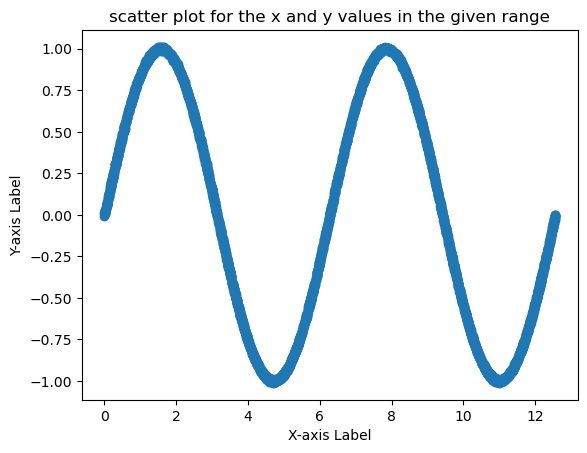

In [62]:
#createing a scatter plot
plt.scatter(X_SAMPLES, Y_SAMPLES)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('scatter plot for the x and y values in the given range')
plt.show()

In [63]:
#defining non linear activation functions 
#defining the first sigmoid function by using the lambda to get [1/(1+e^-x)]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
#identity function to return x 
#this will be used in the final layer 
identity = lambda x: x

In [64]:
#initailization of weights, biases and activation function
weight_matrices = []
bias_vectors = []
activation_functions = []
#iterate over the weight and bias for this it will itterate over the layer transition
for (fan_in,fan_out) in zip(LAYERS[:-1],LAYERS[1:]):
    #using the zip will skip the first and the last element in the list
    #finding the limit for the Xavier Glorot Uniform init
    #which is 6(1+10) = 6/11
    limit = np.sqrt(6/(fan_in+fan_out)) 
    #Xavier Glorot Uniform init
    W = np.random.uniform(
    low = -limit,
    high = +limit,
    size = (fan_in,fan_out),
    )
    #zero bias initialization
    b = np.zeros(fan_out)
    #adding to weight matrix
    weight_matrices.append(W)
    #adding bias to bias vector
    bias_vectors.append(b)
    #adding sigmoid for each layer to activation function except the last layer it will be used as identity
    #sigmoid function by using the lambda to get [1/(1+e^-x)]
    activation_functions.append(sigmoid)
#making the last one as identity
#identity to return x 
#this will be used in the final layer
activation_functions[-1] = identity

In [65]:
# Define the forward pass function
def forward_pass(x, weights, biases, activations):
    a = x

    for W, b, f in zip(weights, biases, activations):
        #Multiply the matrix a with the weight matrix
        a = a @ W
        #Adding the biases to a
        a = a + b
        #Apply the activation function
        a = f(a)

    return a

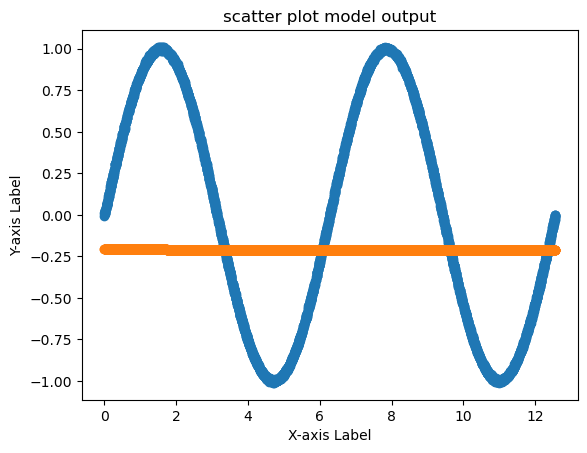

In [66]:
#createing a scatter plot
plt.scatter(X_SAMPLES, Y_SAMPLES)
plt.scatter(X_SAMPLES, forward_pass(X_SAMPLES, weight_matrices, bias_vectors, activation_functions))
plt.title('scatter plot model output')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.show()

In [67]:
#implementing forward loss function
def loss_forward(y_guess, y_ref):
    delta = y_guess - y_ref
    return 0.5 * np.mean(delta**2)

In [68]:
#checking to function for forward loss
loss_forward(
    forward_pass(X_SAMPLES, weight_matrices, bias_vectors, activation_functions),
    Y_SAMPLES,
)

0.2669753092210254

In [69]:
#implementing backward loss function
def loss_backward(y_guess, y_ref):
    delta = y_guess - y_ref
    N = delta.size
    return delta / N

In [70]:
def network_forward_and_backward(x, y_ref, weights, biases, activations, activations_derivatives):
    #Initialize the activated state 'a' with the input data 'x'
    a = x
    #Store the intermediate activated states for the backward pass
    layer_states = [a, ]
    #Iterate through each layer defined by weights, biases, and activation functions
    for W, b, f in zip(weights, biases, activations):
        #Perform a linear transformation by multiplying 'a' with the weight matrix 'W'
        a = a @ W
        #Add the bias vector 'b' to the result of the linear transformation
        a = a + b
        #Apply the activation function 'f' to the result
        a = f(a)
        #Store the current activated state in the layer_states list
        layer_states.append(a)
        
    #The final activated state 'y' is the output of the network
    y = a
    #Calculate the loss between the predicted output 'y' and the reference 'y_ref'
    loss = loss_forward(y, y_ref)
    # Calculate the initial cotangent for the backward pass
    current_cotangent = loss_backward(y, y_ref)
    #Initialize lists to store gradients for weights and biases
    weight_gradients = []
    bias_gradients = []
    #Iterate through the layers in reverse order
    for W, f_prime, a_current, a_prev in zip(
        reversed(weights),
        reversed(activations_derivatives),
        reversed(layer_states[1:]),
        reversed(layer_states[:-1]),
    ):
        #Compute the cotangent for the activated state of the current layer
        activated_state_cotangent = current_cotangent
        #Multiply the cotangent by the derivative of the activation function
        plus_bias_state_cotangent = activated_state_cotangent * f_prime(a_current)
        #Calculate the gradient for the bias vector
        bias_grad = np.sum(plus_bias_state_cotangent, axis=0)
        #Update the state cotangent for the previous layer
        state_cotangent = plus_bias_state_cotangent
        #Calculate the gradient for the weight matrix
        prev_activated_state_cotangent = state_cotangent @ W.T
        weight_grad = a_prev.T @state_cotangent
        # Append the bias and weight gradients to their respective lists
        bias_gradients.append(bias_grad)
        weight_gradients.append(weight_grad)
        # Update the current cotangent for the next iteration (previous layer)
        current_cotangent = prev_activated_state_cotangent
    # Return the loss, reversed weight gradients, and reversed bias gradients
    return loss, reversed(weight_gradients),reversed(bias_gradients)

In [71]:
sigmoid_prime = lambda x_activated:x_activated*(1-x_activated)
identity_prime = lambda x_activated:1

In [72]:
activation_functions_derivatives= [sigmoid_prime,]*(len(LAYERS)-2)+[identity_prime,]
activation_functions_derivatives

[<function __main__.<lambda>(x_activated)>,
 <function __main__.<lambda>(x_activated)>,
 <function __main__.<lambda>(x_activated)>,
 <function __main__.<lambda>(x_activated)>]

In [73]:
network_forward_and_backward(
    X_SAMPLES,
    Y_SAMPLES,
    weight_matrices,
    bias_vectors,
    activation_functions,
    activation_functions_derivatives,
)

(0.2669753092210254,
 <list_reverseiterator at 0x7f123dceffa0>)

In [74]:
#training loop 

loss_history =[]
for epoch in range(N_EPOCH):
    loss, weight_gradients,bias_gradients = network_forward_and_backward(
        X_SAMPLES,
        Y_SAMPLES,
        weight_matrices,
        bias_vectors,
        activation_functions,
        activation_functions_derivatives,
    )
    for W,W_grad,b,b_grad in zip(
        weight_matrices,
        weight_gradients,
        bias_vectors,
        bias_gradients,
    ):
        W -= LEARNING_RATE * W_grad
        b -= LEARNING_RATE * b_grad
    if epoch % 100 ==0:
        print(f"Epoch{epoch},loss:{loss}")
    loss_history.append(loss)
    
        

Epoch0,loss:0.2669753092210254
Epoch100,loss:0.24356133227066015
Epoch200,loss:0.23878600345811093
Epoch300,loss:0.23340085469160043
Epoch400,loss:0.22792742977848054
Epoch500,loss:0.22242870102032117
Epoch600,loss:0.21724818490525621
Epoch700,loss:0.21290887105558917
Epoch800,loss:0.20973798065296123
Epoch900,loss:0.20768449476545678
Epoch1000,loss:0.2064498626300262
Epoch1100,loss:0.20571824422125667
Epoch1200,loss:0.20526766177244699
Epoch1300,loss:0.20496807731690808
Epoch1400,loss:0.20474811490866515
Epoch1500,loss:0.20456898551109307
Epoch1600,loss:0.20440964177440385
Epoch1700,loss:0.20425880613650513
Epoch1800,loss:0.20411025222123863
Epoch1900,loss:0.20395965007380407
Epoch2000,loss:0.203802738336813
Epoch2100,loss:0.20363520130738974
Epoch2200,loss:0.20345468238179437
Epoch2300,loss:0.20326438805373775
Epoch2400,loss:0.20307398987408232
Epoch2500,loss:0.2028930144013226
Epoch2600,loss:0.20272367019266513
Epoch2700,loss:0.20256238479033498
Epoch2800,loss:0.20240475170002367
Ep

Epoch23300,loss:0.06378854034092526
Epoch23400,loss:0.06259317054827432
Epoch23500,loss:0.0614248383934936
Epoch23600,loss:0.06028367487220779
Epoch23700,loss:0.059169713687273404
Epoch23800,loss:0.05808289490285507
Epoch23900,loss:0.057023070162850104
Epoch24000,loss:0.055990009311564094
Epoch24100,loss:0.05498340816970634
Epoch24200,loss:0.054002897154082366
Epoch24300,loss:0.053048050392283094
Epoch24400,loss:0.052118394977477736
Epoch24500,loss:0.05121342003196293
Epoch24600,loss:0.05033258529620733
Epoch24700,loss:0.04947532902473522
Epoch24800,loss:0.04864107504213163
Epoch24900,loss:0.04782923888300682
Epoch25000,loss:0.0470392330020388
Epoch25100,loss:0.04627047108976883
Epoch25200,loss:0.04552237156480034
Epoch25300,loss:0.0447943603339032
Epoch25400,loss:0.04408587292018517
Epoch25500,loss:0.04339635605884861
Epoch25600,loss:0.04272526885309985
Epoch25700,loss:0.04207208357228438
Epoch25800,loss:0.041436286162513526
Epoch25900,loss:0.04081737652837354
Epoch26000,loss:0.040214

Epoch45700,loss:0.013263287011379445
Epoch45800,loss:0.013238389862187006
Epoch45900,loss:0.013213370894679274
Epoch46000,loss:0.013188227028254442
Epoch46100,loss:0.013162955348153937
Epoch46200,loss:0.01313755309790767
Epoch46300,loss:0.013112017672106248
Epoch46400,loss:0.01308634660944786
Epoch46500,loss:0.013060537586013242
Epoch46600,loss:0.01303458840872745
Epoch46700,loss:0.013008497008971486
Epoch46800,loss:0.012982261436311185
Epoch46900,loss:0.012955879852314849
Epoch47000,loss:0.01292935052443451
Epoch47100,loss:0.012902671819929584
Epoch47200,loss:0.012875842199814604
Epoch47300,loss:0.012848860212816083
Epoch47400,loss:0.012821724489326489
Epoch47500,loss:0.012794433735345943
Epoch47600,loss:0.012766986726405158
Epoch47700,loss:0.012739382301465365
Epoch47800,loss:0.01271161935679355
Epoch47900,loss:0.012683696839813305
Epoch48000,loss:0.012655613742933848
Epoch48100,loss:0.0126273690973614
Epoch48200,loss:0.012598961966899008
Epoch48300,loss:0.012570391441742358
Epoch484

Epoch67900,loss:0.002055320621477829
Epoch68000,loss:0.0020194610084922765
Epoch68100,loss:0.001984525372238941
Epoch68200,loss:0.0019504965065668053
Epoch68300,loss:0.001917356770531141
Epoch68400,loss:0.0018850881506127508
Epoch68500,loss:0.0018536723210762563
Epoch68600,loss:0.0018230907022705521
Epoch68700,loss:0.001793324516698378
Epoch68800,loss:0.0017643548427060231
Epoch68900,loss:0.00173616266566795
Epoch69000,loss:0.0017087289265647837
Epoch69100,loss:0.0016820345678758538
Epoch69200,loss:0.0016560605767296462
Epoch69300,loss:0.0016307880252766226
Epoch69400,loss:0.0016061981082687938
Epoch69500,loss:0.001582272177849301
Epoch69600,loss:0.0015589917755724878
Epoch69700,loss:0.0015363386616910725
Epoch69800,loss:0.0015142948417614056
Epoch69900,loss:0.001492842590630897
Epoch70000,loss:0.001471964473883126
Epoch70100,loss:0.0014516433668261464
Epoch70200,loss:0.0014318624711180772
Epoch70300,loss:0.001412605329131095
Epoch70400,loss:0.0013938558361606956
Epoch70500,loss:0.0013

Epoch89800,loss:0.0019957890741589862
Epoch89900,loss:0.0019915438060511235
Epoch90000,loss:0.0019873201864069098
Epoch90100,loss:0.0019831180264020982
Epoch90200,loss:0.001978937139380364
Epoch90300,loss:0.0019747773408324574
Epoch90400,loss:0.0019706384483707665
Epoch90500,loss:0.001966520281708436
Epoch90600,loss:0.001962422662635145
Epoch90700,loss:0.0019583454149935194
Epoch90800,loss:0.0019542883646584183
Epoch90900,loss:0.0019502513395114854
Epoch91000,loss:0.0019462341694179122
Epoch91100,loss:0.0019422366862046174
Epoch91200,loss:0.0019382587236361172
Epoch91300,loss:0.0019343001173930427
Epoch91400,loss:0.0019303607050485555
Epoch91500,loss:0.0019264403260445988
Epoch91600,loss:0.0019225388216697508
Epoch91700,loss:0.0019186560350384254
Epoch91800,loss:0.001914791811064815
Epoch91900,loss:0.0019109459964445318
Epoch92000,loss:0.0019071184396308764
Epoch92100,loss:0.0019033089908107278
Epoch92200,loss:0.0018995175018866905
Epoch92300,loss:0.0018957438264532974
Epoch92400,loss:

Epoch111200,loss:0.001395291589930186
Epoch111300,loss:0.001393406145203485
Epoch111400,loss:0.0013915262483991885
Epoch111500,loss:0.001389651873852626
Epoch111600,loss:0.0013877829960739624
Epoch111700,loss:0.001385919589743739
Epoch111800,loss:0.0013840616297133806
Epoch111900,loss:0.0013822090910032626
Epoch112000,loss:0.0013803619488006575
Epoch112100,loss:0.0013785201784567427
Epoch112200,loss:0.0013766837554892142
Epoch112300,loss:0.001374852655576209
Epoch112400,loss:0.0013730268545572807
Epoch112500,loss:0.0013712063284310946
Epoch112600,loss:0.0013693910533551538
Epoch112700,loss:0.0013675810056427843
Epoch112800,loss:0.0013657761617622583
Epoch112900,loss:0.0013639764983360725
Epoch113000,loss:0.0013621819921373483
Epoch113100,loss:0.0013603926200914857
Epoch113200,loss:0.0013586083592734802
Epoch113300,loss:0.0013568291869053518
Epoch113400,loss:0.0013550550803565547
Epoch113500,loss:0.0013532860171416678
Epoch113600,loss:0.0013515219749195343
Epoch113700,loss:0.00134976293

Epoch132400,loss:0.0010897264921928924
Epoch132500,loss:0.0010886256328047153
Epoch132600,loss:0.001087527200682588
Epoch132700,loss:0.0010864311876639119
Epoch132800,loss:0.0010853375856224514
Epoch132900,loss:0.0010842463864682288
Epoch133000,loss:0.001083157582146732
Epoch133100,loss:0.0010820711646398395
Epoch133200,loss:0.001080987125964108
Epoch133300,loss:0.0010799054581717613
Epoch133400,loss:0.0010788261533505076
Epoch133500,loss:0.0010777492036226138
Epoch133600,loss:0.0010766746011452197
Epoch133700,loss:0.0010756023381097845
Epoch133800,loss:0.0010745324067421213
Epoch133900,loss:0.001073464799302223
Epoch134000,loss:0.0010723995080843022
Epoch134100,loss:0.0010713365254160015
Epoch134200,loss:0.001070275843658618
Epoch134300,loss:0.0010692174552064965
Epoch134400,loss:0.0010681613524876274
Epoch134500,loss:0.0010671075279629165
Epoch134600,loss:0.001066055974125944
Epoch134700,loss:0.0010650066835032072
Epoch134800,loss:0.0010639596486532361
Epoch134900,loss:0.001062914862

Epoch153500,loss:0.0009009859751038689
Epoch153600,loss:0.000900259696242339
Epoch153700,loss:0.0008995346954422097
Epoch153800,loss:0.0008988109691918704
Epoch153900,loss:0.0008980885139911774
Epoch154000,loss:0.0008973673263533648
Epoch154100,loss:0.0008966474028043585
Epoch154200,loss:0.0008959287398825754
Epoch154300,loss:0.0008952113341379413
Epoch154400,loss:0.0008944951821343749
Epoch154500,loss:0.0008937802804474304
Epoch154600,loss:0.0008930666256646695
Epoch154700,loss:0.0008923542143869958
Epoch154800,loss:0.000891643043226098
Epoch154900,loss:0.0008909331088064638
Epoch155000,loss:0.0008902244077646311
Epoch155100,loss:0.0008895169367497301
Epoch155200,loss:0.0008888106924224303
Epoch155300,loss:0.0008881056714551591
Epoch155400,loss:0.0008874018705324766
Epoch155500,loss:0.0008866992863505374
Epoch155600,loss:0.0008859979156179498
Epoch155700,loss:0.0008852977550543342
Epoch155800,loss:0.0008845988013911193
Epoch155900,loss:0.0008839010513718827
Epoch156000,loss:0.00088320

Epoch174600,loss:0.0007714974377036046
Epoch174700,loss:0.0007709789315844899
Epoch174800,loss:0.0007704611761208387
Epoch174900,loss:0.0007699441695796835
Epoch175000,loss:0.0007694279102335718
Epoch175100,loss:0.0007689123963608584
Epoch175200,loss:0.0007683976262450625
Epoch175300,loss:0.0007678835981746391
Epoch175400,loss:0.0007673703104431433
Epoch175500,loss:0.0007668577613504142
Epoch175600,loss:0.0007663459492005724
Epoch175700,loss:0.0007658348723033734
Epoch175800,loss:0.0007653245289733655
Epoch175900,loss:0.000764814917530574
Epoch176000,loss:0.0007643060363001251
Epoch176100,loss:0.0007637978836126059
Epoch176200,loss:0.0007632904578032891
Epoch176300,loss:0.0007627837572127625
Epoch176400,loss:0.0007622777801862721
Epoch176500,loss:0.0007617725250746365
Epoch176600,loss:0.0007612679902331374
Epoch176700,loss:0.0007607641740226618
Epoch176800,loss:0.0007602610748089698
Epoch176900,loss:0.0007597586909630013
Epoch177000,loss:0.0007592570208600866
Epoch177100,loss:0.0007587

Epoch195700,loss:0.0006764200575278627
Epoch195800,loss:0.000676028435756477
Epoch195900,loss:0.0006756372921938242
Epoch196000,loss:0.0006752466258951482
Epoch196100,loss:0.0006748564359185875
Epoch196200,loss:0.000674466721325139
Epoch196300,loss:0.0006740774811767407
Epoch196400,loss:0.0006736887145399617
Epoch196500,loss:0.0006733004204822346
Epoch196600,loss:0.0006729125980743204
Epoch196700,loss:0.0006725252463892255
Epoch196800,loss:0.0006721383645021018
Epoch196900,loss:0.0006717519514914241
Epoch197000,loss:0.0006713660064371649
Epoch197100,loss:0.0006709805284218835
Epoch197200,loss:0.0006705955165308689
Epoch197300,loss:0.0006702109698516729
Epoch197400,loss:0.00066982688747434
Epoch197500,loss:0.0006694432684917668
Epoch197600,loss:0.0006690601119985048
Epoch197700,loss:0.0006686774170915763
Epoch197800,loss:0.0006682951828707919
Epoch197900,loss:0.0006679134084379373
Epoch198000,loss:0.0006675320928977385
Epoch198100,loss:0.0006671512353563681
Epoch198200,loss:0.0006667708

Epoch216800,loss:0.0006031023689373268
Epoch216900,loss:0.0006027940326735969
Epoch217000,loss:0.0006024860204075544
Epoch217100,loss:0.000602178331580669
Epoch217200,loss:0.0006018709656367534
Epoch217300,loss:0.000601563922020344
Epoch217400,loss:0.0006012572001775038
Epoch217500,loss:0.0006009507995558039
Epoch217600,loss:0.0006006447196040159
Epoch217700,loss:0.0006003389597718465
Epoch217800,loss:0.0006000335195103905
Epoch217900,loss:0.0005997283982720568
Epoch218000,loss:0.0005994235955106965
Epoch218100,loss:0.0005991191106816089
Epoch218200,loss:0.0005988149432409946
Epoch218300,loss:0.0005985110926462228
Epoch218400,loss:0.0005982075583557351
Epoch218500,loss:0.0005979043398301918
Epoch218600,loss:0.000597601436530882
Epoch218700,loss:0.0005972988479199748
Epoch218800,loss:0.0005969965734613632
Epoch218900,loss:0.0005966946126198423
Epoch219000,loss:0.0005963929648621476
Epoch219100,loss:0.0005960916296555103
Epoch219200,loss:0.0005957906064686109
Epoch219300,loss:0.000595489

Epoch237900,loss:0.000544453695690744
Epoch238000,loss:0.0005442031052492069
Epoch238100,loss:0.0005439527449652972
Epoch238200,loss:0.000543702614488883
Epoch238300,loss:0.0005434527134696053
Epoch238400,loss:0.0005432030415584485
Epoch238500,loss:0.0005429535984068488
Epoch238600,loss:0.000542704383667054
Epoch238700,loss:0.0005424553969922741
Epoch238800,loss:0.0005422066380359172
Epoch238900,loss:0.0005419581064526435
Epoch239000,loss:0.0005417098018974971
Epoch239100,loss:0.0005414617240261887
Epoch239200,loss:0.0005412138724953056
Epoch239300,loss:0.0005409662469623096
Epoch239400,loss:0.0005407188470850359
Epoch239500,loss:0.0005404716725219181
Epoch239600,loss:0.000540224722932907
Epoch239700,loss:0.0005399779979777931
Epoch239800,loss:0.0005397314973172093
Epoch239900,loss:0.0005394852206126831
Epoch240000,loss:0.0005392391675267188
Epoch240100,loss:0.0005389933377220963
Epoch240200,loss:0.0005387477308622546
Epoch240300,loss:0.0005385023466112523
Epoch240400,loss:0.0005382571

Epoch259000,loss:0.0004961898618776891
Epoch259100,loss:0.0004959810568152038
Epoch259200,loss:0.00049577242157068
Epoch259300,loss:0.0004955639559128705
Epoch259400,loss:0.0004953556596113888
Epoch259500,loss:0.0004951475324365502
Epoch259600,loss:0.0004949395741584775
Epoch259700,loss:0.0004947317845482666
Epoch259800,loss:0.0004945241633765333
Epoch259900,loss:0.0004943167104150536
Epoch260000,loss:0.0004941094254357943
Epoch260100,loss:0.0004939023082120015
Epoch260200,loss:0.0004936953585160051
Epoch260300,loss:0.0004934885761212139
Epoch260400,loss:0.0004932819608017542
Epoch260500,loss:0.0004930755123312751
Epoch260600,loss:0.0004928692304849496
Epoch260700,loss:0.000492663115037799
Epoch260800,loss:0.0004924571657650096
Epoch260900,loss:0.0004922513824425663
Epoch261000,loss:0.0004920457648471189
Epoch261100,loss:0.0004918403127550082
Epoch261200,loss:0.0004916350259436204
Epoch261300,loss:0.0004914299041901927
Epoch261400,loss:0.0004912249472730685
Epoch261500,loss:0.000491020

Epoch279900,loss:0.000455925161496183
Epoch280000,loss:0.00045574741276589194
Epoch280100,loss:0.00045556979374683905
Epoch280200,loss:0.00045539230428092293
Epoch280300,loss:0.00045521494421016026
Epoch280400,loss:0.00045503771337721254
Epoch280500,loss:0.00045486061162495914
Epoch280600,loss:0.00045468363879631917
Epoch280700,loss:0.0004545067947347265
Epoch280800,loss:0.0004543300792838374
Epoch280900,loss:0.0004541534922872938
Epoch281000,loss:0.0004539770335893222
Epoch281100,loss:0.0004538007030343396
Epoch281200,loss:0.0004536245004669147
Epoch281300,loss:0.00045344842573208545
Epoch281400,loss:0.000453272478675363
Epoch281500,loss:0.00045309665914190756
Epoch281600,loss:0.0004529209669773928
Epoch281700,loss:0.0004527454020280677
Epoch281800,loss:0.0004525699641399318
Epoch281900,loss:0.0004523946531599826
Epoch282000,loss:0.00045221946893459847
Epoch282100,loss:0.0004520444113112283
Epoch282200,loss:0.0004518694801368475
Epoch282300,loss:0.0004516946752593874
Epoch282400,loss:

Epoch300700,loss:0.00042153144032327497
Epoch300800,loss:0.0004213776366669605
Epoch300900,loss:0.00042122393502283696
Epoch301000,loss:0.00042107033527984773
Epoch301100,loss:0.00042091683732686325
Epoch301200,loss:0.00042076344105266444
Epoch301300,loss:0.00042061014634646606
Epoch301400,loss:0.00042045695309764295
Epoch301500,loss:0.0004203038611959994
Epoch301600,loss:0.0004201508705311626
Epoch301700,loss:0.00041999798099321404
Epoch301800,loss:0.0004198451924718755
Epoch301900,loss:0.0004196925048575572
Epoch302000,loss:0.0004195399180407502
Epoch302100,loss:0.0004193874319120343
Epoch302200,loss:0.0004192350463625076
Epoch302300,loss:0.0004190827612829884
Epoch302400,loss:0.000418930576564649
Epoch302500,loss:0.0004187784920986355
Epoch302600,loss:0.0004186265077766569
Epoch302700,loss:0.0004184746234903667
Epoch302800,loss:0.0004183228391314238
Epoch302900,loss:0.0004181711545920709
Epoch303000,loss:0.00041801956976464095
Epoch303100,loss:0.00041786808454116503
Epoch303200,loss

Epoch321600,loss:0.00039144974584082024
Epoch321700,loss:0.000391315088576938
Epoch321800,loss:0.0003911805135047325
Epoch321900,loss:0.00039104602054420965
Epoch322000,loss:0.0003909116096147615
Epoch322100,loss:0.0003907772806366442
Epoch322200,loss:0.0003906430335297306
Epoch322300,loss:0.0003905088682144102
Epoch322400,loss:0.00039037478461104896
Epoch322500,loss:0.000390240782639898
Epoch322600,loss:0.00039010686222167625
Epoch322700,loss:0.00038997302327717105
Epoch322800,loss:0.00038983926572686543
Epoch322900,loss:0.00038970558949205577
Epoch323000,loss:0.00038957199449342263
Epoch323100,loss:0.00038943848065217196
Epoch323200,loss:0.0003893050478897539
Epoch323300,loss:0.0003891716961274712
Epoch323400,loss:0.00038903842528698285
Epoch323500,loss:0.00038890523528983014
Epoch323600,loss:0.00038877212605773913
Epoch323700,loss:0.00038863909751255866
Epoch323800,loss:0.000388506149576364
Epoch323900,loss:0.0003883732821710419
Epoch324000,loss:0.0003882404952190791
Epoch324100,los

Epoch342400,loss:0.00036510027056825024
Epoch342500,loss:0.0003649811433683563
Epoch342600,loss:0.00036486208395384835
Epoch342700,loss:0.0003647430922653305
Epoch342800,loss:0.00036462416824355903
Epoch342900,loss:0.00036450531182924607
Epoch343000,loss:0.0003643865229630234
Epoch343100,loss:0.0003642678015855871
Epoch343200,loss:0.000364149147638039
Epoch343300,loss:0.00036403056106149256
Epoch343400,loss:0.0003639120417966017
Epoch343500,loss:0.00036379358978482916
Epoch343600,loss:0.0003636752049675226
Epoch343700,loss:0.00036355688728566396
Epoch343800,loss:0.00036343863668089843
Epoch343900,loss:0.0003633204530945717
Epoch344000,loss:0.0003632023364682196
Epoch344100,loss:0.0003630842867435692
Epoch344200,loss:0.0003629663038620603
Epoch344300,loss:0.000362848387766116
Epoch344400,loss:0.000362730538396972
Epoch344500,loss:0.00036261275569681443
Epoch344600,loss:0.00036249503960772205
Epoch344700,loss:0.0003623773900718089
Epoch344800,loss:0.0003622598070311731
Epoch344900,loss:0

Epoch363200,loss:0.0003416989020682657
Epoch363300,loss:0.0003415927036149912
Epoch363400,loss:0.00034148656212848374
Epoch363500,loss:0.0003413804775632276
Epoch363600,loss:0.00034127444987399995
Epoch363700,loss:0.00034116847901542556
Epoch363800,loss:0.0003410625649423709
Epoch363900,loss:0.0003409567076097459
Epoch364000,loss:0.0003408509069723232
Epoch364100,loss:0.00034074516298537654
Epoch364200,loss:0.0003406394756039049
Epoch364300,loss:0.00034053384478270675
Epoch364400,loss:0.00034042827047702206
Epoch364500,loss:0.00034032275264217894
Epoch364600,loss:0.00034021729123352674
Epoch364700,loss:0.0003401118862060269
Epoch364800,loss:0.00034000653751533623
Epoch364900,loss:0.0003399012451166284
Epoch365000,loss:0.00033979600896556203
Epoch365100,loss:0.00033969082901775974
Epoch365200,loss:0.00033958570522863715
Epoch365300,loss:0.0003394806375538844
Epoch365400,loss:0.00033937562594894377
Epoch365500,loss:0.0003392706703699022
Epoch365600,loss:0.0003391657707724828
Epoch365700,

Epoch384000,loss:0.0003207729062049467
Epoch384100,loss:0.0003206776561618013
Epoch384200,loss:0.00032058245472297024
Epoch384300,loss:0.00032048730185288497
Epoch384400,loss:0.00032039219751601344
Epoch384500,loss:0.00032029714167679734
Epoch384600,loss:0.00032020213429961966
Epoch384700,loss:0.0003201071753491777
Epoch384800,loss:0.00032001226479023753
Epoch384900,loss:0.00031991740258716507
Epoch385000,loss:0.00031982258870477686
Epoch385100,loss:0.0003197278231078027
Epoch385200,loss:0.0003196331057611641
Epoch385300,loss:0.0003195384366294396
Epoch385400,loss:0.0003194438156775922
Epoch385500,loss:0.00031934924287032527
Epoch385600,loss:0.0003192547181726748
Epoch385700,loss:0.00031916024154947733
Epoch385800,loss:0.0003190658129656891
Epoch385900,loss:0.00031897143238671246
Epoch386000,loss:0.00031887709977737795
Epoch386100,loss:0.0003187828151028759
Epoch386200,loss:0.000318688578328102
Epoch386300,loss:0.00031859438941841495
Epoch386400,loss:0.00031850024833896115
Epoch386500,

Epoch404800,loss:0.00030195741162706034
Epoch404900,loss:0.0003018715583040073
Epoch405000,loss:0.0003017857469367258
Epoch405100,loss:0.0003016999774963348
Epoch405200,loss:0.0003016142499541532
Epoch405300,loss:0.00030152856428171095
Epoch405400,loss:0.00030144292045045985
Epoch405500,loss:0.0003013573184317053
Epoch405600,loss:0.0003012717581968372
Epoch405700,loss:0.0003011862397175086
Epoch405800,loss:0.0003011007629652012
Epoch405900,loss:0.00030101532791122423
Epoch406000,loss:0.0003009299345274216
Epoch406100,loss:0.00030084458278512976
Epoch406200,loss:0.000300759272656153
Epoch406300,loss:0.00030067400411198805
Epoch406400,loss:0.0003005887771244031
Epoch406500,loss:0.00030050359166506523
Epoch406600,loss:0.000300418447705623
Epoch406700,loss:0.0003003333452180086
Epoch406800,loss:0.0003002482841741577
Epoch406900,loss:0.00030016326454557565
Epoch407000,loss:0.0003000782863041368
Epoch407100,loss:0.0002999933494217939
Epoch407200,loss:0.0002999084538703109
Epoch407300,loss:0.

Epoch425700,loss:0.00028488502953928044
Epoch425800,loss:0.00028480736041420763
Epoch425900,loss:0.00028472972780087046
Epoch426000,loss:0.00028465213167558367
Epoch426100,loss:0.00028457457201494496
Epoch426200,loss:0.0002844970487953192
Epoch426300,loss:0.00028441956199293
Epoch426400,loss:0.0002843421115844852
Epoch426500,loss:0.00028426469754631623
Epoch426600,loss:0.0002841873198548911
Epoch426700,loss:0.00028410997848676443
Epoch426800,loss:0.0002840326734184697
Epoch426900,loss:0.0002839554046264693
Epoch427000,loss:0.00028387817208748423
Epoch427100,loss:0.00028380097577809695
Epoch427200,loss:0.00028372381567481566
Epoch427300,loss:0.0002836466917542081
Epoch427400,loss:0.0002835696039931723
Epoch427500,loss:0.00028349255236824987
Epoch427600,loss:0.0002834155368562866
Epoch427700,loss:0.00028333855743378446
Epoch427800,loss:0.00028326161407744356
Epoch427900,loss:0.0002831847067641694
Epoch428000,loss:0.0002831078354706945
Epoch428100,loss:0.00028303100017380546
Epoch428200,l

Epoch446600,loss:0.0002694118812939519
Epoch446700,loss:0.0002693413586422246
Epoch446800,loss:0.0002692708679772083
Epoch446900,loss:0.00026920040927910327
Epoch447000,loss:0.0002691299825280928
Epoch447100,loss:0.00026905958770441095
Epoch447200,loss:0.0002689892247881172
Epoch447300,loss:0.000268918893759494
Epoch447400,loss:0.00026884859459885423
Epoch447500,loss:0.00026877832728665953
Epoch447600,loss:0.0002687080918029638
Epoch447700,loss:0.0002686378881282226
Epoch447800,loss:0.00026856771624263914
Epoch447900,loss:0.0002684975761265217
Epoch448000,loss:0.00026842746776043944
Epoch448100,loss:0.0002683573911246525
Epoch448200,loss:0.0002682873461995953
Epoch448300,loss:0.00026821733296561
Epoch448400,loss:0.0002681473514031271
Epoch448500,loss:0.00026807740149261593
Epoch448600,loss:0.00026800748321442584
Epoch448700,loss:0.00026793759654917935
Epoch448800,loss:0.00026786774147722383
Epoch448900,loss:0.000267797917979152
Epoch449000,loss:0.00026772812603538374
Epoch449100,loss:0

Epoch467400,loss:0.00025540364280935866
Epoch467500,loss:0.00025533936911504386
Epoch467600,loss:0.00025527512360481265
Epoch467700,loss:0.0002552109062619125
Epoch467800,loss:0.00025514671706945073
Epoch467900,loss:0.0002550825560104887
Epoch468000,loss:0.0002550184230685329
Epoch468100,loss:0.00025495431822649496
Epoch468200,loss:0.00025489024146781565
Epoch468300,loss:0.0002548261927756588
Epoch468400,loss:0.00025476217213331906
Epoch468500,loss:0.00025469817952383664
Epoch468600,loss:0.00025463421493072475
Epoch468700,loss:0.0002545702783371812
Epoch468800,loss:0.0002545063697264609
Epoch468900,loss:0.00025444248908169643
Epoch469000,loss:0.0002543786363864622
Epoch469100,loss:0.00025431481162413515
Epoch469200,loss:0.0002542510147779753
Epoch469300,loss:0.0002541872458314188
Epoch469400,loss:0.00025412350476780723
Epoch469500,loss:0.00025405979157029683
Epoch469600,loss:0.00025399610622241117
Epoch469700,loss:0.0002539324487074734
Epoch469800,loss:0.00025386881900909625
Epoch46990

Epoch488200,loss:0.0002426174898044131
Epoch488300,loss:0.00024255873370275941
Epoch488400,loss:0.00024250000253827326
Epoch488500,loss:0.00024244129629648697
Epoch488600,loss:0.0002423826149629363
Epoch488700,loss:0.00024232395852326905
Epoch488800,loss:0.0002422653269630084
Epoch488900,loss:0.00024220672026754788
Epoch489000,loss:0.00024214813842270323
Epoch489100,loss:0.00024208958141429504
Epoch489200,loss:0.00024203104922772693
Epoch489300,loss:0.00024197254184866714
Epoch489400,loss:0.00024191405926269068
Epoch489500,loss:0.00024185560145553465
Epoch489600,loss:0.0002417971684127832
Epoch489700,loss:0.0002417387601201445
Epoch489800,loss:0.00024168037656342492
Epoch489900,loss:0.00024162201772825608
Epoch490000,loss:0.00024156368360044934
Epoch490100,loss:0.00024150537416549133
Epoch490200,loss:0.00024144708940917887
Epoch490300,loss:0.00024138882931714817
Epoch490400,loss:0.0002413305938754872
Epoch490500,loss:0.00024127238306988858
Epoch490600,loss:0.00024121419688588483
Epoch4

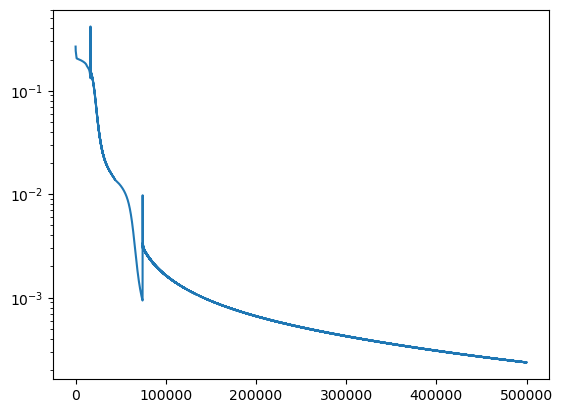

In [75]:
plt.plot(loss_history)
plt.yscale("log")

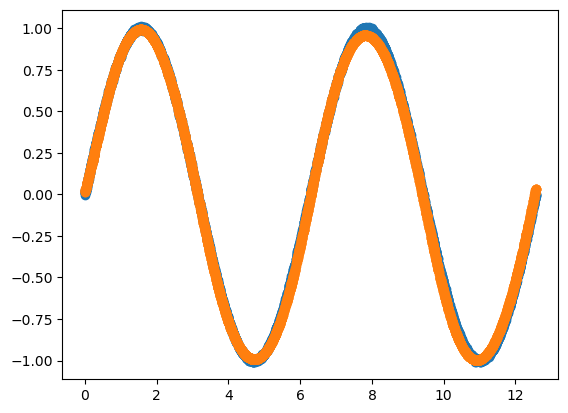

In [76]:
plt.scatter(X_SAMPLES, Y_SAMPLES)
plt.scatter(X_SAMPLES, forward_pass(X_SAMPLES, weight_matrices, bias_vectors, activation_functions))